# Part 2 - Validation on testes peptides

Here is the procedure used to predicty activity, selectivity and hemolysis in all possible single, double, and triple mutants of protegrin-1. 

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted

import joblib
from sklearn.decomposition import PCA
from sklearn import metrics

pd.set_option('display.max_columns', 100)

%matplotlib inline

In [3]:
# This function wil convert the undefined MIC values to 100.
def convert_mic(mic_value):
    if type(mic_value) == str and mic_value.startswith('>'):
        mic_value = float(mic_value.replace('>', ''))
        v = 100
        return v
    else:
        return float(mic_value)

In [4]:
# load meta_data with mutations on PG1
meta_data = pd.read_csv('results/predictions_MIC_SEL_HEMO_models_PG1_1-3mut_validation_set_v01.csv', index_col=0)
meta_data

,ID2,Sequence,RGGRLCYCRRRFCVCVGR,Select,Charge,ID,group,MIC MH,%hemo,L10Select,selectivity,MBC_8_prob,selectivity_pred,hemolysis_pred
0,bsPG-1.1,RGGRLQYCRRRFCVARGR,-----Q--------AR--,-0.82,6.742145,PG1_3mut_1739000,<-0.25,16,0.428850,0.836425,6.861598,100.0,-0.82,-3.26
1,bsPG-1.2,RGGRLQYCRRRGCVTVGR,-----Q-----G--T---,-0.76,5.742155,PG1_3mut_1218602,<-0.25,4,0.341131,0.134981,1.364522,100.0,-0.76,-9.08
2,bsPG-1.3,RGGRLAYCRRRDCTCVGR,-----A-----D-T----,-0.65,4.651497,PG1_3mut_1896424,CP,>64,-0.165692,NaN,NaN,100.0,-0.65,-1.97
3,bsPG-1.4,RGGRLDYCRRRFCVTTGR,-----D--------TT--,-0.56,4.742406,PG1_3mut_1275003,<-0.25,64,0.165692,1.025482,10.604288,100.0,-0.56,-5.19
4,bsPG-1.5,RGGRLQACRRRFCVTVGR,-----QA-------T---,-0.44,5.744660,PG1_3mut_257802,<-0.25,8,0.721248,0.761174,5.769981,100.0,-0.44,-6.20
5,bsPG-1.6,RGGRLRYCRRRFDVSVGR,-----R------D-S---,-0.43,5.833305,PG1_3mut_1210489,<-0.25,16,0.735867,1.070920,11.773879,100.0,-0.43,-9.15
6,bsPG-1.7,RGGRLCTARRRFCVRVGR,------TA------R---,-0.43,6.744650,PG1_3mut_1536372,<-0.25,2,0.906433,0.258366,1.812865,100.0,-0.43,-6.51
7,bsPG-1.8,RGGRLTYCRRRFCTAVGR,-----T-------TA---,-0.40,5.742155,PG1_3mut_1147726,<-0.25,16,0.043860,-0.153815,0.701754,100.0,-0.40,-6.28
8,bsPG-1.9,RGGRLTYCRRRDCVAVGR,-----T-----D--A---,-0.29,4.742406,PG1_3mut_1980555,<-0.25,32,0.116959,0.573184,3.742690,100.0,-0.29,-12.57
9,bsPG-1.10,RGGRLAYCRRRFCVDTGR,-----A--------DT--,-0.28,4.742406,PG1_3mut_1658870,<-0.25,64,0.092593,0.772756,5.925926,100.0,-0.28,-3.90


## Load embeddings

In [5]:
######################## Load the embedding ######################
dir_path = 'data/embedding/esm2_15B_PG1_validation/'
embeddings = {}
for file in os.listdir(dir_path):
        file_path = str(dir_path) + file 
        label = file.split('.pt')[0]
        embeddings[label] = np.array(torch.load(file_path)['mean_representations'][48])


# here I creating a dictionary with ID as key and semantic value as value 
data = meta_data.merge(pd.DataFrame.from_dict(embeddings, orient='index'), how='inner', left_on='ID2', right_index=True)


features = data.iloc[:,meta_data.shape[1]:]
features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,5070,5071,5072,5073,5074,5075,5076,5077,5078,5079,5080,5081,5082,5083,5084,5085,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5096,5097,5098,5099,5100,5101,5102,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,0.109975,-0.134590,-0.111443,0.218644,-0.237748,0.131493,-0.119502,0.234007,-0.042554,0.338132,-0.181911,-0.070123,0.285914,0.132456,0.145206,-0.119641,0.016052,-0.160409,0.175323,0.006981,0.031700,0.035921,-0.388611,0.106619,-0.263324,0.010144,0.089600,-0.232413,0.044148,0.205849,-0.088589,-0.051135,-0.249299,-0.100425,-0.034155,-0.042539,0.145001,-0.053556,0.325825,0.009630,0.188548,-0.276242,0.057267,0.159372,-0.074977,0.383486,-0.059249,0.067180,-0.192458,-0.160447,...,-0.287571,-0.199986,0.265588,-0.087591,-0.035537,0.052414,-0.032724,0.074804,0.253470,0.188196,0.000840,-0.048806,0.006446,0.150435,0.038589,0.085381,-0.230726,0.268536,-0.116890,-0.014526,-0.264989,-0.072022,-0.083098,-0.169087,0.285792,0.045038,0.190472,-0.006061,0.086329,-0.000662,0.091908,0.035746,-0.148846,-0.118648,-0.209491,-0.021450,-0.027162,-0.213849,-0.050013,0.006487,-0.136047,-0.087660,0.107472,-0.270478,0.122341,-0.089307,0.137297,0.075365,-0.198461,-0.035045
1,0.129701,-0.184889,-0.115536,0.161651,-0.224050,0.112427,-0.157890,0.269912,-0.049523,0.307800,-0.149578,-0.081749,0.265789,0.177847,0.169391,-0.094384,0.128813,-0.176698,0.105074,0.014042,0.026007,0.069966,-0.333289,0.142775,-0.248938,-0.029828,0.020388,-0.144963,0.050747,0.161994,-0.136832,-0.064507,-0.254568,-0.029669,-0.057159,0.031107,0.171488,-0.025439,0.370129,-0.041123,0.135727,-0.279007,0.066811,0.166149,-0.087821,0.364228,-0.020949,0.117404,-0.246447,-0.102719,...,-0.252198,-0.117499,0.283669,-0.081878,-0.082878,0.056859,-0.002050,0.037367,0.262278,0.109654,0.026107,0.013662,0.029625,0.179096,0.087634,0.068997,-0.194529,0.256631,-0.086368,0.013377,-0.315640,-0.012413,-0.098380,-0.130370,0.274497,0.049318,0.221853,-0.059104,0.077843,-0.038710,0.128514,0.042598,-0.170303,-0.052412,-0.178424,-0.050331,-0.044874,-0.277650,0.018790,-0.008888,-0.106790,-0.129787,0.076798,-0.208119,0.098149,-0.133004,0.089372,0.093026,-0.170869,-0.013929
2,0.099468,-0.114953,-0.117187,0.183187,-0.209792,0.091260,-0.130392,0.256235,-0.053187,0.229403,-0.153716,-0.110329,0.224579,0.217258,0.185253,-0.137833,0.123428,-0.071266,0.113991,-0.005573,0.083241,0.095849,-0.291120,0.084410,-0.293609,-0.046842,0.064312,-0.096830,0.032436,0.084759,-0.103322,-0.039152,-0.284039,-0.067096,-0.115826,0.051603,0.165042,-0.094658,0.376194,-0.128548,0.181254,-0.249639,0.065785,0.160171,-0.091013,0.350580,0.005549,0.078152,-0.205696,-0.069624,...,-0.265148,-0.125474,0.232081,-0.136144,-0.026184,0.075733,0.041864,0.058491,0.310277,0.156786,-0.067325,0.029883,0.027132,0.108766,0.068593,-0.053529,-0.139792,0.200807,-0.150195,0.036576,-0.200391,-0.061608,-0.052911,-0.173216,0.241643,0.071768,0.181315,-0.034740,0.006019,-0.071225,0.139590,0.150875,-0.073768,-0.083165,-0.124568,-0.063161,-0.023962,-0.257893,0.000161,0.006935,-0.195330,-0.116773,0.137988,-0.164647,0.119364,-0.178338,0.031593,0.029154,-0.215111,-0.017543
3,0.156776,-0.105166,-0.063266,0.204592,-0.202521,0.076685,-0.140390,0.251750,-0.082083,0.299491,-0.138542,-0.093754,0.238516,0.210513,0.224224,-0.099772,0.084619,-0.138276,0.065005,0.034831,0.028210,0.085703,-0.210246,0.129641,-0.316469,-0.079329,0.070912,-0.132105,-0.009244,0.151050,-0.079498,-0.048807,-0.207856,-0.036181,-0.060802,0.062600,0.129042,-0.139074,0.310381,-0.097736,0.152451,-0.305469,0.069221,0.137120,-0.135764,0.433612,-0.017008,0.039403,-0.203412,-0.054635,...,-0.269408,-0.143549,0.283143,-0.004776,-0.062685,0.133809,0.033932,0.047367,0.329623,0.135072,-0.037661,0.074512,0.027695,0.104189,0.026622,0.066428,-0.113747,0.263858,-0.121201,0.010072,-0.256017,-0.060592,-0.097629,-0.164075,0.268416,-0.001478,0.174

# Predictions

## Hemolysis

In [8]:
# load PCA weights and models for hemolysis prediction
pca30 = joblib.load('models/pca30_weights_v03.pkl') # hemo
X30 = pca30.transform(features)
hemo = joblib.load('models/model_v03_Lasso30_esm2_15B_hemolysis_regression.pkl')

In [9]:
res_hemo = data.iloc[:,:meta_data.shape[1]]

# calculates the the hemolysis score
pred = hemo.predict(X30)
res_hemo['hemolysis_pred_v02']= pred

#number of peptides with hemolysis score < 1
print(f"{res_hemo.query('hemolysis_pred_v02 <= 2').shape[0]} peptides with predicted hemolysis% <= 2%")

31 peptides with predicted hemolysis% <= 2%


In [10]:
# Model evaluation on test data
true_hemo = res_hemo['%hemo']
pred_hemo = res_hemo['hemolysis_pred_v02']

r2 = metrics.r2_score(true_hemo, pred_hemo)
mae = metrics.mean_absolute_error(true_hemo, pred_hemo)
print(f'R2: {r2}, MAE: {mae}')

from scipy.stats import spearmanr

# Calculate the Spearman correlation coefficient between x and y
corr, pval = spearmanr(true_hemo, pred_hemo)

# Print the correlation coefficient and p-value
print(f"Spearman correlation coefficient: {corr:.2f}")
print(f"P-value: {pval:.2f}")

R2: -1.4950545890455826, MAE: 3.5165091179551724
Spearman correlation coefficient: 0.32
P-value: 0.06


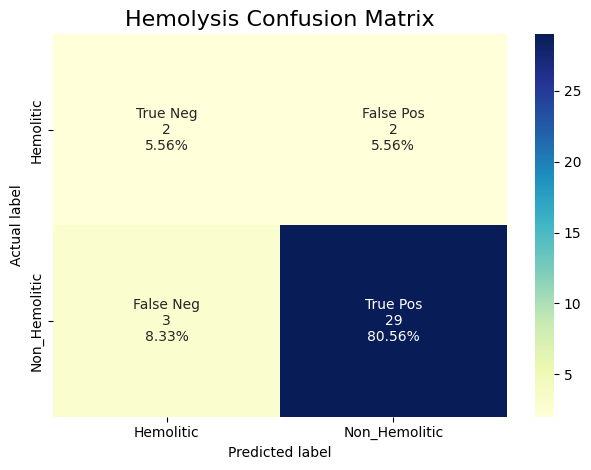

In [11]:
#confusion_matrix, 
true = [1 if x <=2 else 0 for x in true_hemo]
pred = [1 if x<=2 else 0 for x in pred_hemo]

conf_m = metrics.confusion_matrix(true, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in conf_m.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in conf_m.flatten()/np.sum(conf_m)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)


labelsx = ['Hemolitic', 'Non_Hemolitic']
sns.heatmap(conf_m, annot=labels, fmt='', cmap="YlGnBu", yticklabels=labelsx, xticklabels=labelsx)
plt.title('Hemolysis Confusion Matrix', fontsize=16)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [12]:
accuracy = metrics.accuracy_score(true, pred)
recall = metrics.recall_score(true, pred)
precision = metrics.precision_score(true, pred)
f1_score = metrics.f1_score(true, pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.86
Recall: 0.91
Precision: 0.94
F1 Score: 0.92


## Selectivity

In [14]:
cutoff_sel = 0.5

In [16]:

# load PCA weights and models for selectivity prediction
pca35 = joblib.load('models/pca35_weights_v03.pkl') # sel
X35 = pca35.transform(features)

model_sel = joblib.load('models/model_v03_Lasso35_esm2_15B_selectivity_regression.pkl')

In [17]:
res_sel = data.iloc[:,:meta_data.shape[1]]
# calculates the selectivity score
pred = model_sel.predict(X35)
res_sel['selectivity_pred_v02']= pred

#number of peptides with hemolysis score < 1
print(f"{res_sel.query('selectivity_pred_v02 < 1').shape[0]} peptides with predicted hemolysis% < 0.5")

32 peptides with predicted hemolysis% < 0.5


In [18]:
res = res_sel[~res_sel['L10Select'].isna()]
# Model evaluation on test data
true_sel = res['L10Select']
pred_sel = res['selectivity_pred_v02']

r2 = metrics.r2_score(true_sel, pred_sel)
mae = metrics.mean_absolute_error(true_sel, pred_sel)
print(f'R2: {r2}, MAE: {mae}')

from scipy.stats import spearmanr

# Calculate the Spearman correlation coefficient between x and y
corr, pval = spearmanr(true_sel, pred_sel)

# Print the correlation coefficient and p-value
print(f"Spearman correlation coefficient: {corr:.2f}")
print(f"P-value: {pval:.2f}")

R2: -0.06151500617122685, MAE: 0.4316403056751375
Spearman correlation coefficient: 0.30
P-value: 0.12


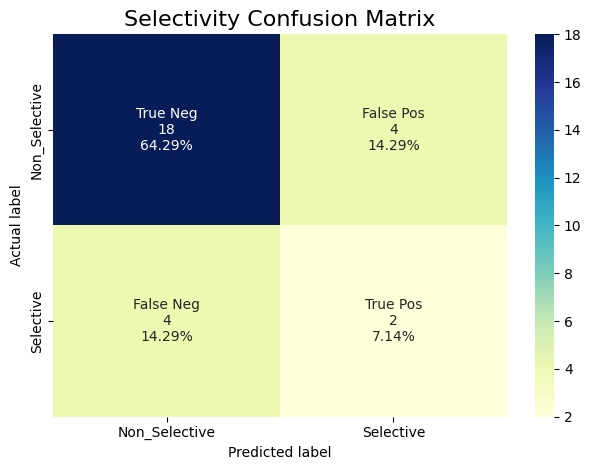

In [19]:
#confusion_matrix, 
true = [1 if x<=cutoff_sel else 0 for x in true_sel]
pred = [1 if x<=cutoff_sel else 0 for x in pred_sel]

conf_m = metrics.confusion_matrix(true, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in conf_m.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in conf_m.flatten()/np.sum(conf_m)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)


labelsx = ['Non_Selective', 'Selective']
sns.heatmap(conf_m, annot=labels, fmt='', cmap="YlGnBu", yticklabels=labelsx, xticklabels=labelsx)
plt.title('Selectivity Confusion Matrix', fontsize=16)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [20]:
accuracy = metrics.accuracy_score(true, pred)
recall = metrics.recall_score(true, pred)
precision = metrics.precision_score(true, pred)
f1_score = metrics.f1_score(true, pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.71
Recall: 0.33
Precision: 0.33
F1 Score: 0.33


## Activity

In [73]:
cutoff=90

In [74]:
# This function wil convert the undefined MIC values or MIC > 8 to 0.
def convert_mic(mic_value):
    if type(mic_value) == str and mic_value.startswith('>'):
        return 0
    elif float(mic_value) > 8:
        return 0
    else:
        return 1
    

In [75]:
# load PCA weights and models for activity prediction
pca40 = joblib.load('models/pca40_weights_v03.pkl') # mic
X40 = pca40.transform(features)
#
model_mic = joblib.load('models/model_v03_logR40_esm2_15B_activity_classification.pkl')

In [76]:
res_mic = data.iloc[:,:meta_data.shape[1]]

# calculates the probability of being active
prob= model_mic.predict_proba(X40)
res_mic['MIC_pred_v02']= [(x[1]*100).round(2) for x in prob]

#number of peptides with hemolysis score < 1
res_mic.query('MIC_pred_v02 > 90')

,ID2,Sequence,RGGRLCYCRRRFCVCVGR,Select,Charge,ID,group,MIC MH,%hemo,L10Select,selectivity,MBC_8_prob,selectivity_pred,hemolysis_pred,MIC_pred_v02
1,bsPG-1.2,RGGRLQYCRRRGCVTVGR,-----Q-----G--T---,-0.76,5.742155,PG1_3mut_1218602,<-0.25,4,0.341131,0.134981,1.364522,100.0,-0.76,-9.08,90.66
2,bsPG-1.3,RGGRLAYCRRRDCTCVGR,-----A-----D-T----,-0.65,4.651497,PG1_3mut_1896424,CP,>64,-0.165692,NaN,NaN,100.0,-0.65,-1.97,94.16
3,bsPG-1.4,RGGRLDYCRRRFCVTTGR,-----D--------TT--,-0.56,4.742406,PG1_3mut_1275003,<-0.25,64,0.165692,1.025482,10.604288,100.0,-0.56,-5.19,92.43
4,bsPG-1.5,RGGRLQACRRRFCVTVGR,-----QA-------T---,-0.44,5.744660,PG1_3mut_257802,<-0.25,8,0.721248,0.761174,5.769981,100.0,-0.44,-6.20,94.70
6,bsPG-1.7,RGGRLCTARRRFCVRVGR,------TA------R---,-0.43,6.744650,PG1_3mut_1536372,<-0.25,2,0.906433,0.258366,1.812865,100.0,-0.43,-6.51,96.11
7,bsPG-1.8,RGGRLTYCRRRFCTAVGR,-----T-------TA---,-0.40,5.742155,PG1_3mut_1147726,<-0.25,16,0.043860,-0.153815,0.701754,100.0,-0.40,-6.28,97.32
8,bsPG-1.9,RGGRLTYCRRRDCVAVGR,-----T-----D--A---,-0.29,4.742406,PG1_3mut_1980555,<-0.25,32,0.116959,0.573184,3.742690,100.0,-0.29,-12.57,95.09
9,bsPG-1.10,RGGRLAYCRRRFCVDTGR,-----A--------DT--,-0.28,4.742406,PG1_3mut_1658870,<-0.25,64,0.092593,0.772756,5.925926,100.0,-0.28,-3.90,90.28
10,bsPG-1.11,RGGRLRYCRRRGTVCVGR,-----R-----GT-----,-0.28,6.742145,PG1_3mut_1618529,CP,>64,0.268031,NaN,NaN,100.0,-0.28,-2.79,90.71
13,bsPG-1.14,RGGRLCTARRRFCVHVGR,------TA------H---,-0.22,5.835569,PG1_3mut_1926344,-0.25-0,16,0.638402,1.009214,10.214425,100.0,-0.22,-2.34,91.72


In [77]:
# Load meta data
res_mic['Active'] = [convert_mic(x) for x in res_mic['MIC MH']]
res_mic

,ID2,Sequence,RGGRLCYCRRRFCVCVGR,Select,Charge,ID,group,MIC MH,%hemo,L10Select,selectivity,MBC_8_prob,selectivity_pred,hemolysis_pred,MIC_pred_v02,Active
0,bsPG-1.1,RGGRLQYCRRRFCVARGR,-----Q--------AR--,-0.82,6.742145,PG1_3mut_1739000,<-0.25,16,0.428850,0.836425,6.861598,100.0,-0.82,-3.26,87.40,0
1,bsPG-1.2,RGGRLQYCRRRGCVTVGR,-----Q-----G--T---,-0.76,5.742155,PG1_3mut_1218602,<-0.25,4,0.341131,0.134981,1.364522,100.0,-0.76,-9.08,90.66,1
2,bsPG-1.3,RGGRLAYCRRRDCTCVGR,-----A-----D-T----,-0.65,4.651497,PG1_3mut_1896424,CP,>64,-0.165692,NaN,NaN,100.0,-0.65,-1.97,94.16,0
3,bsPG-1.4,RGGRLDYCRRRFCVTTGR,-----D--------TT--,-0.56,4.742406,PG1_3mut_1275003,<-0.25,64,0.165692,1.025482,10.604288,100.0,-0.56,-5.19,92.43,0
4,bsPG-1.5,RGGRLQACRRRFCVTVGR,-----QA-------T---,-0.44,5.744660,PG1_3mut_257802,<-0.25,8,0.721248,0.761174,5.769981,100.0,-0.44,-6.20,94.70,1
5,bsPG-1.6,RGGRLRYCRRRFDVSVGR,-----R------D-S---,-0.43,5.833305,PG1_3mut_1210489,<-0.25,16,0.735867,1.070920,11.773879,100.0,-0.43,-9.15,85.81,0
6,bsPG-1.7,RGGRLCTARRRFCVRVGR,------TA------R---,-0.43,6.744650,PG1_3mut_1536372,<-0.25,2,0.906433,0.258366,1.812865,100.0,-0.43,-6.51,96.11,1
7,bsPG-1.8,RGGRLTYCRRRFCTAVGR,-----T-------TA---,-0.40,5.742155,PG1_3mut_1147726,<-0.25,16,0.043860,-0.153815,0.701754,100.0,-0.40,-6.28,97.32,0
8,bsPG-1.9,RGGRLTYCRRRDCVAVGR,-----T-----D--A---,-0.29,4.742406,PG1_3mut_1980555,<-0.25,32,0.116959,0.573184,3.742690,100.0,-0.29,-12.57,95.09,0
9,bsPG-1.10,RGGRLAYCRRRFCVDTGR,-----A--------DT--,-0.28,4.742406,PG1_3mut_1658870,<-0.25,64,0.092593,0.772756,5.925926,100.0,-0.28,-3.90,90.28,0


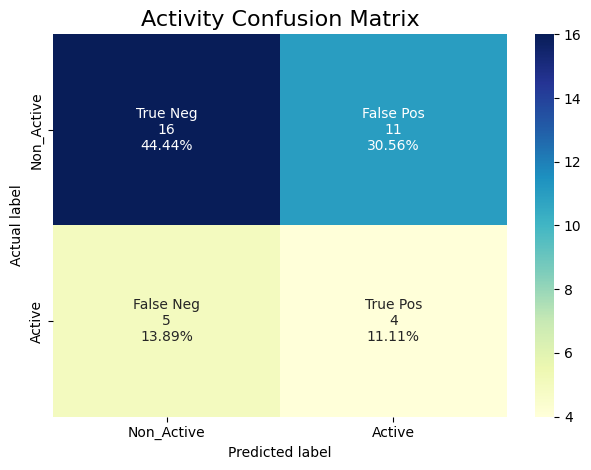

In [78]:
#confusion_matrix, 
true = res_mic['Active']
pred = [1 if x>cutoff else 0 for x in res_mic['MIC_pred_v02']]

conf_m = metrics.confusion_matrix(true, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in conf_m.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in conf_m.flatten()/np.sum(conf_m)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

labelsx = ['Non_Active', 'Active']
sns.heatmap(conf_m, annot=labels, fmt='', cmap="YlGnBu", yticklabels=labelsx, xticklabels=labelsx)
plt.title('Activity Confusion Matrix', fontsize=16)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [79]:
accuracy = metrics.accuracy_score(true, pred)
recall = metrics.recall_score(true, pred)
precision = metrics.precision_score(true, pred)
f1_score = metrics.f1_score(true, pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.56
Recall: 0.44
Precision: 0.27
F1 Score: 0.33


In [80]:
stop

NameError: name 'stop' is not defined

# Overall Performance

In [ ]:
df_dict={'Version': 'V02', 'Feature': 'Activity', 'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1 Score': f1_score}
df = pd.concat([df, pd.DataFrame(df_dict, index=[0])])
df

,Version,Feature,Accuracy,Recall,Precision,F1 Score
0,V01,Hemolysis,0.944444,1.000000,0.944444,0.971429
1,V01,Selectivity,0.214286,1.000000,0.214286,0.352941
2,V01,Activity,0.250000,1.000000,0.250000,0.400000
0,V02,Hemolysis,0.777778,0.843750,0.900000,0.870968
0,V02,Selectivity,0.785714,0.000000,0.000000,0.000000
0,V02,Activity,0.777778,0.333333,0.600000,0.428571


In [ ]:
#df.to_csv('results/model_v01-2_performance.csv', index=False)
df = pd.read_csv('results/model_v01-2_performance.csv')
df

,Version,Feature,Accuracy,Recall,Precision,F1 Score
0,V01,Hemolysis,0.944444,1.000000,0.944444,0.971429
1,V01,Selectivity,0.214286,1.000000,0.214286,0.352941
2,V01,Activity,0.250000,1.000000,0.250000,0.400000
3,V02,Hemolysis,0.777778,0.843750,0.900000,0.870968
4,V02,Selectivity,0.785714,0.000000,0.000000,0.000000
5,V02,Activity,0.777778,0.333333,0.600000,0.428571


In [ ]:
# id_vars: Columns that should remain unaltered.
# value_vars: Columns that you want to melt (i.e., unpivot). These columns will be transformed from wide format to long format.
# var_name: Name of the new column that will store the melted columns' names (default is 'variable').
# value_name: Name of the new column that will store the values (default is 'value').

df_melted = pd.melt(df, 
        id_vars=['Version', 'Feature'],
        value_vars=['Accuracy', 'Recall', 'Precision', 'F1 Score'],
        var_name='Metric',
        value_name='Score')

df_melted= df_melted.sort_values(by=['Version', 'Feature', 'Metric']).reset_index(drop=True)
df_melted

,Version,Feature,Metric,Score
0,V01,Activity,Accuracy,0.250000
1,V01,Activity,F1 Score,0.400000
2,V01,Activity,Precision,0.250000
3,V01,Activity,Recall,1.000000
4,V01,Hemolysis,Accuracy,0.944444
5,V01,Hemolysis,F1 Score,0.971429
6,V01,Hemolysis,Precision,0.944444
7,V01,Hemolysis,Recall,1.000000
8,V01,Selectivity,Accuracy,0.214286
9,V01,Selectivity,F1 Score,0.352941


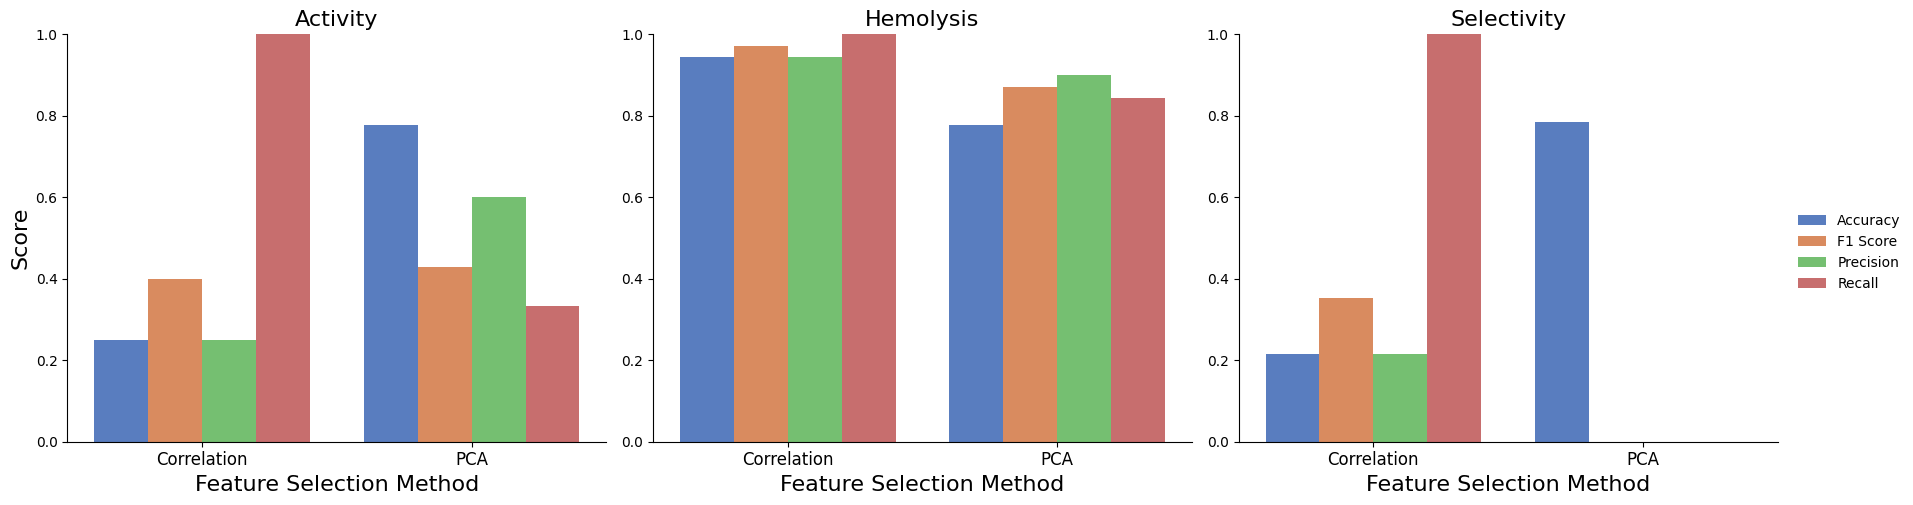

In [ ]:
g = sns.FacetGrid(df_melted, col="Feature", sharey=False, height=5, aspect=1.2, ylim=(0,1))#col_order=['Train_Accuracy', 'Test_Accuracy']
g.map_dataframe(sns.barplot, x="Version", y="Score", hue='Metric', palette='muted')
g.set_axis_labels("Feature Selection Method", "Score", size=16)


axes = g.axes.flatten()
axes[0].set_title("Activity", size=16)
axes[1].set_title("Hemolysis", size=16)
axes[2].set_title("Selectivity", size=16)

tick_labels = ['Correlation', 'PCA']
for ax in axes: 
    ax.set_xticks(range(len(tick_labels)))  # Set x-tick positions
    ax.set_xticklabels(tick_labels, size=12) 


g.add_legend()
plt.savefig('results/model_v01-2_performance.png', dpi=1200)

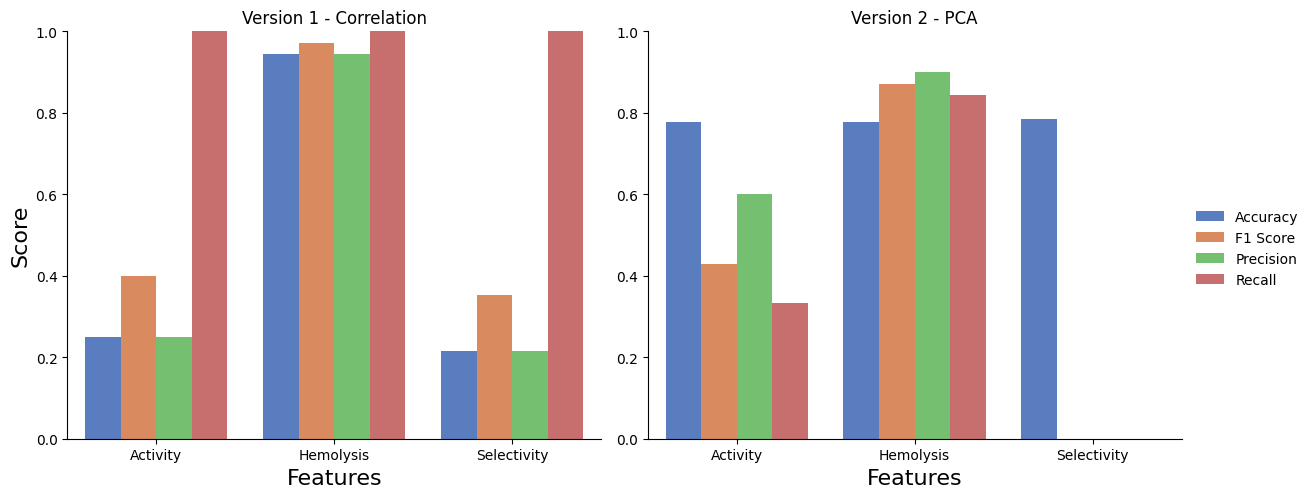

In [ ]:
g = sns.FacetGrid(df_melted, col="Feature", sharey=False, height=5, aspect=1.2, ylim=(0,1))#col_order=['Train_Accuracy', 'Test_Accuracy']
g.map_dataframe(sns.barplot, x="Feature", y="Score", hue='Metric', palette='muted')
g.set_axis_labels("Features", "Score", size=16)
#g.set_titles(col_template="{col_name}", row_template="{row_name}")
axes = g.axes.flatten()
axes[0].set_title("Version 1 - Correlation")
axes[1].set_title("Version 2 - PCA")
axes[1].set_title("Version 2 - PCA")

g.add_legend()
plt.savefig('results/model_v01-2_performance.png', dpi=1200)

## Merging results

In [ ]:
cols =['ID2', 'Sequence', 'RGGRLCYCRRRFCVCVGR', 'Select', 'Charge', 'ID',
       'group', 'MIC MH', '%hemo', 'L10Select', 'L10select_adj',
       'MIC_8_pred_v01', 'selectivity_pred_v01', 'hemolysis_pred_v01',
       'MIC_pred_v02', 'selectivity_pred_v02', 'hemolysis_pred_v02',
       'Active', 'Hemolitic', 'Selective']

In [ ]:


results = res_mic.merge(res_sel[['ID', 'selectivity_pred_v02']], how='inner', left_on='ID', right_on='ID')
results = results.merge(res_hemo[['ID', 'hemolysis_pred_v02']], how='inner', left_on='ID', right_on='ID')
results.rename(columns={'MBC_8_prob': 'MIC_8_pred_v01', 'selectivity_pred': 'selectivity_pred_v01',
                        'hemolysis_pred': 'hemolysis_pred_v01'}, inplace=True)

results['Hemolitic'] = [0 if x <=2 else 1 for x in results['%hemo']]
results['MIC MH'].replace('>64', 100, inplace=True)
results['MIC MH'] = results['MIC MH'].astype('float64')
results['L10select_adj'] = np.log10((results['%hemo']+0.2) * results['MIC MH']) -0.2
results['Selective'] = [1 if x <=0.5 else 0 for x in results['selectivity']]
results[cols]

,ID2,Sequence,RGGRLCYCRRRFCVCVGR,Select,Charge,ID,group,MIC MH,%hemo,L10Select,L10select_adj,MIC_8_pred_v01,selectivity_pred_v01,hemolysis_pred_v01,MIC_pred_v02,selectivity_pred_v02,hemolysis_pred_v02,Active,Hemolitic,Selective
0,bsPG-1.1,RGGRLQYCRRRFCVARGR,-----Q--------AR--,-0.82,6.742145,PG1_3mut_1739000,<-0.25,16.0,0.428850,0.836425,0.802667,100.0,-0.82,-3.26,78.41,0.557508,0.590117,0,0,0
1,bsPG-1.2,RGGRLQYCRRRGCVTVGR,-----Q-----G--T---,-0.76,5.742155,PG1_3mut_1218602,<-0.25,4.0,0.341131,0.134981,0.135362,100.0,-0.76,-9.08,75.10,0.740651,-2.766209,1,0,0
2,bsPG-1.3,RGGRLAYCRRRDCTCVGR,-----A-----D-T----,-0.65,4.651497,PG1_3mut_1896424,CP,100.0,-0.165692,NaN,0.335395,100.0,-0.65,-1.97,83.90,0.901413,-6.983588,0,0,0
3,bsPG-1.4,RGGRLDYCRRRFCVTTGR,-----D--------TT--,-0.56,4.742406,PG1_3mut_1275003,<-0.25,64.0,0.165692,1.025482,1.169295,100.0,-0.56,-5.19,88.48,0.956146,-2.599533,0,0,0
4,bsPG-1.5,RGGRLQACRRRFCVTVGR,-----QA-------T---,-0.44,5.744660,PG1_3mut_257802,<-0.25,8.0,0.721248,0.761174,0.667466,100.0,-0.44,-6.20,91.66,0.780367,-3.030275,1,0,0
5,bsPG-1.6,RGGRLRYCRRRFDVSVGR,-----R------D-S---,-0.43,5.833305,PG1_3mut_1210489,<-0.25,16.0,0.735867,1.070920,0.975334,100.0,-0.43,-9.15,87.00,0.641219,-0.658212,0,0,0
6,bsPG-1.7,RGGRLCTARRRFCVRVGR,------TA------R---,-0.43,6.744650,PG1_3mut_1536372,<-0.25,2.0,0.906433,0.258366,0.144955,100.0,-0.43,-6.51,92.13,0.647984,-6.559199,1,0,0
7,bsPG-1.8,RGGRLTYCRRRFCTAVGR,-----T-------TA---,-0.40,5.742155,PG1_3mut_1147726,<-0.25,16.0,0.043860,-0.153815,0.391260,100.0,-0.40,-6.28,91.98,0.891747,-0.803467,0,0,0
8,bsPG-1.9,RGGRLTYCRRRDCVAVGR,-----T-----D--A---,-0.29,4.742406,PG1_3mut_1980555,<-0.25,32.0,0.116959,0.573184,0.806153,100.0,-0.29,-12.57,92.41,0.628099,-5.202780,0,0,0
9,bsPG-1.10,RGGRLAYCRRRFCVDTGR,-----A--------DT--,-0.28,4.742406,PG1_3mut_1658870,<-0.25,64.0,0.092593,0.772756,1.072443,100.0,-0.28,-3.90,88.46,0.770239,2.169155,0,0,0


In [ ]:
#results.to_excel('results/predictions_MIC_SEL_HEMO_models_PG1_1-3mut_validation_set_v01-02.xlsx')